In [1]:
from tensorflow.keras.layers import (Conv2D, BatchNormalization, MaxPooling2D, 
                                   GlobalAveragePooling2D, GlobalAveragePooling1D, 
                                   Dense, Dropout, Input, Concatenate, 
                                   LayerNormalization, MultiHeadAttention,
                                   Layer, Lambda)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, BatchNormalization, MaxPooling2D, 
                                   GlobalAveragePooling2D, Dense, Dropout, Input, 
                                   Concatenate, LayerNormalization, MultiHeadAttention,
                                   Layer, Lambda)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                      ModelCheckpoint, CSVLogger)
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np



# Data augmentation setup
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

class PatchExtractor(Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtractor, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dim = self.patch_size * self.patch_size * 3
        patches = tf.reshape(patches, [batch_size, -1, patch_dim])
        return patches

def create_cnn_model(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.35)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

def create_vit_classifier(input_shape=(128, 128, 3), patch_size=16, num_heads=8, transformer_layers=4):
    inputs = Input(shape=input_shape)
    
    # Extract patches
    patches = PatchExtractor(patch_size)(inputs)
    
    # Embedding dimension
    embedding_dim = 256
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    
    # Patch embedding
    x = Dense(embedding_dim)(patches)
    
    # Add position embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=embedding_dim)(positions)
    x = x + tf.expand_dims(pos_embed, axis=0)
    
    # Transformer blocks
    for _ in range(transformer_layers):
        # Normalization and attention
        att = LayerNormalization(epsilon=1e-6)(x)
        att = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(att, att)
        x = att + x
        
        # Normalization and MLP
        mlp = LayerNormalization(epsilon=1e-6)(x)
        mlp = Dense(embedding_dim * 2, activation='gelu')(mlp)
        mlp = Dropout(0.1)(mlp)
        mlp = Dense(embedding_dim)(mlp)
        x = mlp + x
    
    # Global pooling
    x = LayerNormalization(epsilon=1e-6)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

def create_hybrid_model(input_shape=(128, 128, 3)):
    # Create base models
    cnn_model = create_cnn_model(input_shape)
    vit_model = create_vit_classifier(input_shape)
    
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Get features from both models
    cnn_features = cnn_model(inputs)
    vit_features = vit_model(inputs)
    
    # Combine features
    combined = Concatenate()([cnn_features, vit_features])
    
    # Classification head
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# F1 Score metric remains the same
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.round(y_pred), tf.float32)
        
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-7)
        f1 = 2 * precision * recall / (precision + recall + 1e-7)
        return f1

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

def train_model(model, train_generator, validation_generator, epochs=50):
    # Compute class weights
    labels = train_generator.classes
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    # Compile model
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=0.0001
    )
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', F1Score(), 
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()]
    )
    
    # Callbacks - Updated the ModelCheckpoint filepath
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7
        ),
        ModelCheckpoint(
            'best_model.keras',  # Changed from .h5 to .keras
            monitor='val_loss',
            save_best_only=True
        ),
        CSVLogger('training_history.csv')
    ]
    
    # Train model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    
    return history

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/chest-x-ray-images/FinalData/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/chest-x-ray-images/FinalData/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/chest-x-ray-images/FinalData/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Create and train model
model = create_hybrid_model()
history = train_model(model, train_generator, validation_generator)

# Evaluate model
test_results = model.evaluate(test_generator)
print('Test Results:', dict(zip(model.metrics_names, test_results)))

Found 13964 images belonging to 2 classes.
Found 3490 images belonging to 2 classes.
Found 2096 images belonging to 2 classes.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732463707.494834     122 service.cc:145] XLA service 0x7dd1600047b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732463707.494924     122 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732463707.494929     122 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732463722.775682     166 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_175', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1732463727.820719     16

  2/437 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.5781 - f1_score: 0.5759 - loss: 1.9194 - precision: 0.7009 - recall: 0.5802   

I0000 00:00:1732463754.594223     122 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_28', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1732463754.631645     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


367/437 ━━━━━━━━━━━━━━━━━━━━ 25s 358ms/step - accuracy: 0.5463 - f1_score: 0.5784 - loss: 1.7296 - precision: 0.7643 - recall: 0.5239

I0000 00:00:1732463907.695241     252 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_25', 932 bytes spill stores, 932 bytes spill loads

I0000 00:00:1732463908.123903     253 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_27', 932 bytes spill stores, 932 bytes spill loads

I0000 00:00:1732463909.837276     253 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_175', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1732463914.523245     252 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_175', 968 bytes spill stores, 924 bytes spill loads



370/437 ━━━━━━━━━━━━━━━━━━━━ 31s 467ms/step - accuracy: 0.5465 - f1_score: 0.5784 - loss: 1.7292 - precision: 0.7644 - recall: 0.5240

I0000 00:00:1732463926.665204     119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_29', 48 bytes spill stores, 48 bytes spill loads



437/437 ━━━━━━━━━━━━━━━━━━━━ 325s 599ms/step - accuracy: 0.5496 - f1_score: 0.5791 - loss: 1.7201 - precision: 0.7678 - recall: 0.5266 - val_accuracy: 0.7146 - val_f1_score: 0.8336 - val_loss: 1.7317 - val_precision: 0.7146 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 155s 349ms/step - accuracy: 0.6098 - f1_score: 0.5994 - loss: 1.5611 - precision: 0.8079 - recall: 0.5905 - val_accuracy: 0.8238 - val_f1_score: 0.7712 - val_loss: 1.2081 - val_precision: 0.8254 - val_recall: 0.9555 - learning_rate: 1.0000e-04
Epoch 3/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 157s 355ms/step - accuracy: 0.6358 - f1_score: 0.6104 - loss: 1.4707 - precision: 0.8327 - recall: 0.6156 - val_accuracy: 0.7181 - val_f1_score: 0.8325 - val_loss: 2.0442 - val_precision: 0.7171 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 158s 356ms/step - accuracy: 0.6687 - f1_score: 0.6249 - loss: 1.3947 - precision: 0.8527 - recall: 0.6530 - val_accurac

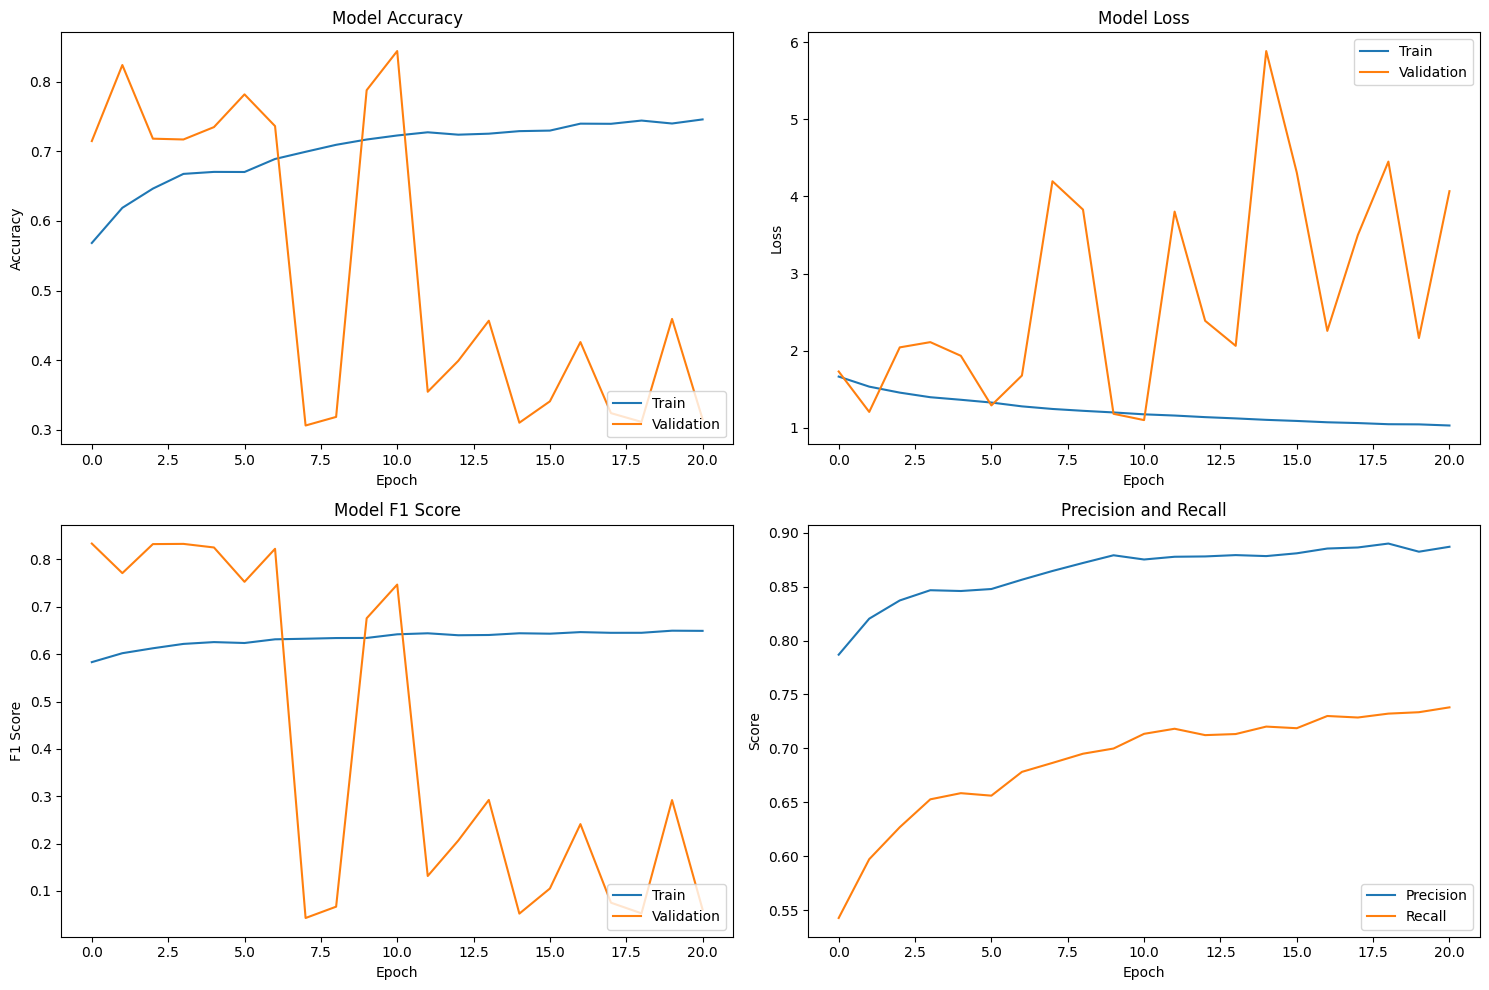

66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step


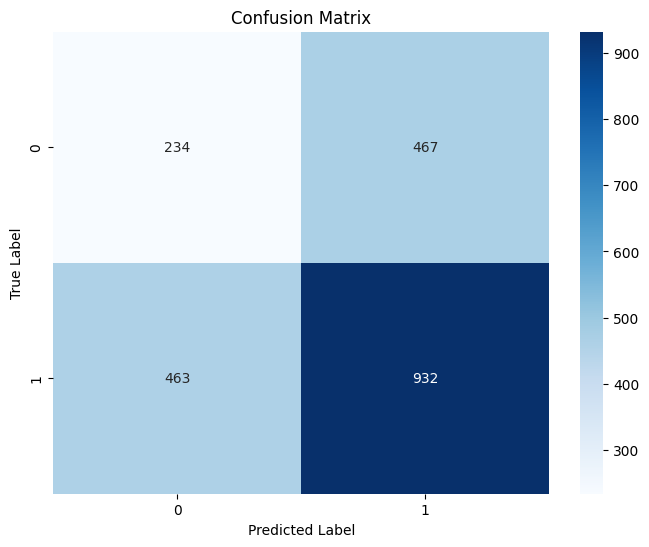


Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.33      0.33       701
           1       0.67      0.67      0.67      1395

    accuracy                           0.56      2096
   macro avg       0.50      0.50      0.50      2096
weighted avg       0.56      0.56      0.56      2096



KeyError: 'lr'

<Figure size 1000x400 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_training_history(history):
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'])
    axes[0, 0].plot(history.history['val_accuracy'])
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend(['Train', 'Validation'], loc='lower right')
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'])
    axes[0, 1].plot(history.history['val_loss'])
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(['Train', 'Validation'], loc='upper right')
    
    # Plot F1 Score
    axes[1, 0].plot(history.history['f1_score'])
    axes[1, 0].plot(history.history['val_f1_score'])
    axes[1, 0].set_title('Model F1 Score')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend(['Train', 'Validation'], loc='lower right')
    
    # Plot Precision & Recall
    axes[1, 1].plot(history.history['precision'])
    axes[1, 1].plot(history.history['recall'])
    axes[1, 1].set_title('Precision and Recall')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend(['Precision', 'Recall'], loc='lower right')
    
    plt.tight_layout()
    plt.show()

def generate_confusion_matrix(model, test_generator):
    # Get predictions
    Y_pred = model.predict(test_generator)
    Y_pred = (Y_pred > 0.5).astype(int)
    
    # Get true labels
    Y_test = test_generator.classes
    
    # Calculate confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))

# After training the model, add these lines:
plot_training_history(history)
generate_confusion_matrix(model, test_generator)

# You can also add learning rate visualization if you want to see how it changed
plt.figure(figsize=(10, 4))
plt.plot(history.history['lr'])
plt.title('Learning Rate over Time')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.yscale('log')
plt.show()

# To check for overfitting specifically, you can add this helper function
def check_overfitting(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Calculate the difference between training and validation loss
    loss_diff = np.array(train_loss) - np.array(val_loss)
    
    print("\nOverfitting Analysis:")
    print(f"Final training loss: {train_loss[-1]:.4f}")
    print(f"Final validation loss: {val_loss[-1]:.4f}")
    print(f"Difference between training and validation loss: {loss_diff[-1]:.4f}")
    
    if loss_diff[-1] < -0.1:
        print("Model shows signs of underfitting (validation loss < training loss)")
    elif loss_diff[-1] > 0.1:
        print("Model shows signs of overfitting (training loss < validation loss)")
        print("Suggestions to reduce overfitting:")
        print("1. Increase dropout rates")
        print("2. Add more data augmentation")
        print("3. Reduce model complexity")
        print("4. Add more regularization")
    else:
        print("Model seems well balanced (similar training and validation loss)")

# Call the overfitting check
check_overfitting(history)

# Print the best validation loss achieved
best_val_loss = min(history.history['val_loss'])
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"\nBest validation loss: {best_val_loss:.4f} (epoch {best_epoch})")